In [71]:
%load_ext autoreload
# Set extension to reload modules every time before executing code
%autoreload 2  #0 to turn of reloading

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [72]:
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

In [73]:
import bokeh
import time
import copy
import scipy.stats as ss
from scipy.optimize import curve_fit
from coffea import hist, processor, nanoevents, util
from coffea.nanoevents.methods import candidate
from coffea.nanoevents import NanoAODSchema, BaseSchema

import awkward as ak
import numpy as np
import glob as glob
import itertools
import pandas as pd
from numpy.random import RandomState

from dask.distributed import Client
import inspect
import matplotlib.pyplot as plt
import matplotlib as mpl

from pltStyle import pltStyle
import os
# %matplotlib notebook 
# %matplotlib notebook 

### Import processor

In [74]:
from CoffeaJERCProcessor_L5 import Processor

Parameters of the run

In [105]:
UsingDaskExecutor = True
CERNCondorCluster = False
CoffeaCasaEnv     = False
load_preexisting  = True    ### True if don't repeat the processing of files and use preexisting JER from output
test_run          = False     ### True if run only on one file
load_fit_res      = False

fine_etabins      = False
one_bin           = False


tag = '_L5'

exec('from CoffeaJERCProcessor'+tag+' import Processor') 

add_tag = '_LHEflav1_Herwig-TTBAR-JME' #'_Herwig-TTBAR' # '_TTBAR' #'_QCD' # '_testing_19UL18' # '' #fine_etaBins

# add_tag='_fine_etaBins'+add_tag
tag_full = tag+add_tag

outname = 'out/CoffeaJERCOutputs'+tag_full+'.coffea'
outname = outname+'_test' if test_run else outname

# if fine_etabins:
#     tag_full='_oneBin'+tag_full

if one_bin:
    tag_full='_oneBin'+tag_full
    
if load_preexisting == True:
    UsingDaskExecutor = False
    
if UsingDaskExecutor == False:
    CERNCondorCluster = False
    
if not os.path.exists("out"):
    os.mkdir("out")
    
if not os.path.exists("out_txt"):
    os.mkdir("out_txt")
    
if test_run and not os.path.exists("test"):
    os.mkdir("test/")
    os.mkdir("test/out_txt")
    os.mkdir("test/fig")

In [76]:
## assume running on the LPC
xrootdstr = 'root://cmsxrootd.fnal.gov/'
# assume running on the lxplus
# xrootdstr = 'root://cms-xrd-global.cern.ch//'
# xrootdstr = 'root://xrootd-cms.infn.it/'

# if running on coffea casa instead...
if CoffeaCasaEnv:
    xrootdstr = 'root://xcache/'
    
# dataset = 'fileNames/fileNames_QCD20UL18.txt'
# dataset = 'fileNames/fileNames_Herwig_20UL18.txt'
dataset = 'fileNames/fileNames_TTToSemi20UL18.txt'
dataset = 'fileNames/fileNames_QCD20UL18.txt'
dataset = 'fileNames/fileNames_QCD20UL18_JMENano.txt'
dataset = 'fileNames/fileNames_TTToSemi20UL18_JMENano.txt'
dataset = 'fileNames/fileNames_TTToDilep20UL18_JMENano.txt'
dataset = 'fileNames/fileNames_TTToHad20UL18_JMENano.txt'
# dataset = 'fileNames/fileNames_Herwig_20UL18_JMENano.txt'


rootfiles = open(dataset).read().split()

fileslist = [xrootdstr + file for file in rootfiles]
fileslist = fileslist[:40] # if add_tag=='QCD' else fileslist # :20 to skim the events

/tmp/anpotreb/ipykernel_26721/2840957501.py:22: ResourceWarning: unclosed file <_io.TextIOWrapper name='fileNames/fileNames_TTToHad20UL18_JMENano.txt' mode='r' encoding='UTF-8'>
  rootfiles = open(dataset).read().split()


In [77]:
def find_xsec(key):
    semilepxsec = 0.108*3*0.337*2*2
    dilepxsec = 0.108*3*0.108*3
    hadxsec = 0.337*2*0.337*2

    if "TTToSemi" in key:
        xsec = semilepxsec
    elif "TTToDilep" in key:
        xsec = dilepxsec
    elif "TTToHad" in key:
        xsec = hadxsec
    else:
        xsec = 1
    return xsec

xsec = find_xsec(dataset)

In [78]:
datasets = ['fileNames/fileNames_TTToSemi20UL18_JMENano.txt',
           'fileNames/fileNames_TTToDilep20UL18_JMENano.txt',
           'fileNames/fileNames_TTToHad20UL18_JMENano.txt'
           ]

for data_s in datasets:
    rootfiles = open(dataset).read().split()
    fileslist = [xrootdstr + file for file in rootfiles]
    fileslist = fileslist[:40]
filesets = {'QCD': {"files": fileslist, "metadata": {"xsec": xsec}}}

fileslist = fileslist
if test_run:
    fileslist = [fileslist[1]]

/tmp/anpotreb/ipykernel_26721/2376032711.py:7: ResourceWarning: unclosed file <_io.TextIOWrapper name='fileNames/fileNames_TTToHad20UL18_JMENano.txt' mode='r' encoding='UTF-8'>
  rootfiles = open(dataset).read().split()


Test if certificate works to open the file

In [79]:
import os
### RUN THIS CELL ONLY IF YOU ARE USING SWAN 

##### REMEMBER TO MANUALLY COPY THE PROXY TO YOUR CERNBOX FOLDER AND TO MODIFY THE NEXT LINE
os.environ['X509_USER_PROXY'] = '/afs/cern.ch/user/a/anpotreb/k5-ca-proxy.pem'
if os.path.isfile(os.environ['X509_USER_PROXY']):
    print("Found proxy at {}".format(os.environ['X509_USER_PROXY']))
else:
    print("os.environ['X509_USER_PROXY'] ",os.environ['X509_USER_PROXY'])
os.environ['X509_CERT_DIR'] = '/cvmfs/cms.cern.ch/grid/etc/grid-security/certificates'
os.environ['X509_VOMS_DIR'] = '/cvmfs/cms.cern.ch/grid/etc/grid-security/vomsdir'

Found proxy at /afs/cern.ch/user/a/anpotreb/k5-ca-proxy.pem


In [80]:
import uproot

In [81]:
ff = uproot.open(fileslist[0])
ff.keys()
ff.close()

['tag;1',
 'Events;1',
 'LuminosityBlocks;1',
 'Runs;1',
 'MetaData;1',
 'ParameterSets;1']

# Dask Setup:
---
### For Coffea-Casa, the client must be specified according to the user that is logged into the Coffea-Casa Environment.
#### 1.) go to the left of this coffea-casa session to the task bar and click the orange-red button; it will say "Dask" if you hover your cursor over it
#### 2.) scroll down to the blue box where it shows the "Scheduler Address"
#### 3.) write that full address into the dask Client function 
#### Example: `client = Client("tls://ac-2emalik-2ewilliams-40cern-2ech.dask.coffea.casa:8786")`
---
### For CMSLPC, the client must be specified with the LPCCondorCluster
#### 1.) follow installation instructions from https://github.com/CoffeaTeam/lpcjobqueue, if you have not already done so, to get a working singularity environment with access to lpcjobqueue and LPCCondorCluster class
#### 2.) import LPCCondorCluster: `from lpcjobqueue import LPCCondorCluster`
#### 3.) define the client
#### Example: 
`cluster = LPCCondorCluster()`

`client = Client(cluster)`


In [82]:
# ak.type(light_match_candidates.pt)
# bla.pdgId

In [83]:
# Dask set up for Coffea-Casa only
if(UsingDaskExecutor and CoffeaCasaEnv):
    client = Client("tls://ac-2emalik-2ewilliams-40cern-2ech.dask.coffea.casa:8786")
    client.upload_file('CoffeaJERCProcessor.py')

In [84]:
# import logging
# logging.basicConfig(format='%(levelname)s:%(message)s', level=logging.WARNING)

In [85]:
# Dask set up for LPC only 
if(UsingDaskExecutor and not CoffeaCasaEnv):
    from dask.distributed import Client 
    if not CERNCondorCluster:
        client = Client()

    else:
        from dask_lxplus import CernCluster
        import socket

        cluster = CernCluster(
            cores = 4,
            memory = '1000MB',
            disk = '20MB',
            death_timeout = '60',
            lcg = True,
            nanny = False,
            container_runtime = 'none',
            log_directory = '/eos/user/a/anpotreb/condor/log',
            scheduler_options = {
                'port': 8786,
                'host': socket.gethostname(),
            },
            job_extra = {
                'MY.JobFlavour': '"espresso"',
    #             'transfer_input_files': '/afs/cern.ch/user/a/anpotreb/top/JERC/JMECoffea/CoffeaJERCProcessor_L5.py',
            },
        )
        cluster.adapt(minimum=1, maximum=30)
        cluster.scale(8)
        client = Client(cluster)
    
    client.upload_file('CoffeaJERCProcessor'+tag+'.py')

    client

In [86]:
# import sys
# import re
# if not re.match('^/cvmfs/sft(?:-nightlies)?.cern.ch/lcg/latest/.+/python[2,3]?$', sys.executable):
#     "print"
# sys.executable

In [87]:
tstart = time.time()

outputs_unweighted = {}

seed = 1234577890
prng = RandomState(seed)
Chunk = [10000, 5] # [chunksize, maxchunks]

# filedict = {f"MC": {"files": fileslist, "metadata": {"xsec": xsec}}}
filesets = {'QCD': {"files": fileslist, "metadata": {"xsec": xsec}}}

if not load_preexisting:
    for name,files in filesets.items(): 
        if not UsingDaskExecutor:
            chosen_exec = 'futures'
            output = processor.run_uproot_job({name:files},
                                              treename='Events',
                                              processor_instance=Processor(),
                                              executor=processor.iterative_executor,
        #                                        executor=processor.futures_executor,
                                              executor_args={
                                                  'skipbadfiles':False,
                                                  'schema': NanoAODSchema, #BaseSchema
                                                  'workers': 2},
                                              chunksize=Chunk[0])#, maxchunks=Chunk[1])
        else:
            chosen_exec = 'dask'
            output = processor.run_uproot_job({name:files},
                                              treename='Events',
                                              processor_instance=Processor(),
                                              executor=processor.dask_executor,
                                              executor_args={
                                                  'client': client,
                                                  'skipbadfiles':False,
                                                  'schema': NanoAODSchema, #BaseSchema
    #                                               'workers': 2
                                              },
                                              chunksize=Chunk[0])#, maxchunks=Chunk[1])

    elapsed = time.time() - tstart
    print("Processor finished. Time elapsed: ", elapsed)
    outputs_unweighted[name] = output
    print("Saving the output histograms under: ", outname)
    util.save(output, outname)
    outputs_unweighted[name] = output
else:
    output = util.load(outname)
    print("Loaded histograms from: ", outname)
   

if UsingDaskExecutor:
    client.close()
    if CERNCondorCluster or CoffeaCasaEnv:
        cluster.close()

Loaded histograms from:  out/CoffeaJERCOutputs_L5_LHEflav1_Herwig-TTBAR-JME.coffea


### Fit responses

define gaussian function for fitting the responses

In [88]:
def gauss(x, *p):
    A, mu, sigma = p
    return A*np.exp(-(x-mu)**2/(2.*sigma**2))

Define some global variables for the fit

In [89]:
f_xvals = np.linspace(0,5,5001)
# fine_etabins = False

if fine_etabins==True:
    ptbins = np.array([15, 40, 150, 400, 4000, 10000])
    ptbins_c = (ptbins[:-1]+ptbins[1:])/2
    etabins = output['ptresponse'].axis('jeteta').edges()
elif one_bin==True:
    ptbins = np.array([15, 10000])
    ptbins_c = (ptbins[:-1]+ptbins[1:])/2
    etabins = np.array([etabins[0], 0, etabins[-1]])
else:
    ptbins = output['ptresponse'].axis('pt').edges()
    ptbins_c = output['ptresponse'].axis('pt').centers()
    etabins = np.array([-5, -3, -2.5, -1.3, 0, 1.3, 2.5, 3, 5])

    
jetpt_length = len(ptbins)-1
jeteta_length = (len(etabins)-1)//2

etabins_mod = etabins[(len(etabins)-1)//2:]
etabins_c = (etabins_mod[:-1]+etabins_mod[1:])/2 #output['ptresponse'].axis('jeteta').centers()

ptresp_edd = output['ptresponse'].axis('ptresponse').edges()
plot_pt_edges = ptresp_edd[0:np.nonzero(ptresp_edd>=2.0)[0][0]]
hist_pt_edges = plot_pt_edges[1:-1]   #for plotting. To exclude overflow from the plot
plot_response_axis = hist.Bin("jeteta", r"Jet $\eta$", hist_pt_edges)

In [90]:
from pltStyle import pltStyle
pltStyle(style='paper')
plt.rcParams['figure.subplot.left'] = 0.162
plt.rcParams['figure.dpi'] = 150

### Testing adding hists

In [91]:
# k=2
# i=5
# etaBinPl = hist.Interval(etabins[k+jeteta_length], etabins[k+1+jeteta_length])
# etaBinMi = hist.Interval(etabins[jeteta_length-k-1], etabins[jeteta_length-k])
# ptBin = hist.Interval(ptbins[i], ptbins[i+1])

# etaBinPl
# etaBinMi
# ptBin

In [92]:
# samp = '_b'
# # etaBinMi = ''
# histoMi = output['ptresponse'+samp].integrate('jeteta', etaBinMi).integrate('pt', ptBin)
# histoPl = output['ptresponse'+samp].integrate('jeteta', etaBinPl).integrate('pt', ptBin)
# histo = (histoMi+histoPl)
            

In [93]:
# # keys = []

# for key in histo.values().keys():
# #     keys.append(key)
#     histo[key].scale(find_xsec(key))
    
# histo_sum = histo.integrate('dataset').values()[()]

    
# histo_sum = histo[keys[0]]
# for key in keys[:-1]:
#     histo_sum += histo[key]

In [94]:
combineTTbar = False
if combineTTbar==True:
    N_evts_had = 41113000
    N_evts_semilep = 48065000
    N_evts_dilep = 41160000

    N_evts = np.array([N_evts_had, N_evts_semilep, N_evts_dilep])

    N_av = (N_evts_had+N_evts_semilep+N_evts_dilep)/3

    semilepxsec = 0.108*3*0.337*2*2
    dilepxsec = 0.108*3*0.108*3
    hadxsec = 0.337*2*0.337*2

    xsec = np.array([hadxsec, semilepxsec, dilepxsec])
    weights = N_evts/N_av*xsec

    # (N_evts/N_av*xsec).sum()

    add_tags = ['_LHEflav1_TTBAR-Had-JME', '_LHEflav1_TTBAR-JME', '_LHEflav1_TTBAR-Dilep-JME']
    tag_fulls = [tag+addtag for addtag in add_tags]
    outnames = ['out/CoffeaJERCOutputs'+tag_full+'.coffea' for tag_full in tag_fulls]

    outputs = [util.load(outname) for outname in outnames]
    
    tag_full = tag + '_LHEflav1_TTBAR-Inclusive-JME'

In [95]:
# if combineTTbar:
#     histoMi = outputs[0]['ptresponse'+samp].integrate('jeteta', etaBinMi).integrate('pt', ptBin).copy()
#     histoPl = outputs[0]['ptresponse'+samp].integrate('jeteta', etaBinPl).integrate('pt', ptBin).copy()
#     histo = (histoMi+histoPl)
#     histo.values()[('QCD',)][1:10] 
#     histo.scale(weights[0])
    
#     histo.values()[('QCD',)][1:10] 
    

#     for out, wg in zip(outputs[1:], weights[1:]):
#         histoMi = out['ptresponse'+samp].integrate('jeteta', etaBinMi).integrate('pt', ptBin).copy()
#         histoPl = out['ptresponse'+samp].integrate('jeteta', etaBinPl).integrate('pt', ptBin).copy()
#         histo2 = histoMi+histoPl
#         histo2.scale(wg)
#         histo2.values()[('QCD',)][1:10]
#         histo.add(histo2)
        
#     histo.values()[('QCD',)][1:10]

In [96]:
# for samp in subsamples:
#     if combine_antiflavour and (samp in barable_samples):
#         comb = True

#     if combineTTbar:
#         if comb==True:
            
        
#     else:
#         if comb==True:
#             output_hist['ptresponse'+samp] = output['ptresponse'+samp] + output['ptresponse'+samp+'bar']
#         else:
#             output_hist['ptresponse'+samp] = output['ptresponse'+samp]


In [97]:
combine_antiflavour = True

In [98]:
import warnings
# warnings.filterwarnings('ignore') ### To suppress warnings with bad
barable_samples = ['_b', '_c', '_s', 'ud_']

def fit_responses(output, samp='_b'):
    warnings.filterwarnings('ignore')
    
#     if combine_antiflavour and not (samp in barable_samples):
#         combine_antiflavour = False
#     if combine_antiflavour and (samp in barable_samples):
#         if combineTTbar:    
#             outputs = [outii['ptresponse'+samp].copy() +
#                        outii['ptresponse'+samp+'bar'].copy() for outii in outputs ]
#         else:
#             output = outputs[0]['ptresponse'+samp].copy() + outputs[0]['ptresponse'+samp+'bar'].copy()
        
    
    if combineTTbar:
        if combine_antiflavour and (samp in barable_samples):
            response_hist = outputs[0]['ptresponse'+samp].copy() + outputs[0]['ptresponse'+samp+'bar'].copy()            
        else:
            response_hist = outputs[0]['ptresponse'+samp].copy()
        response_hist.scale(weights[0])
        for out, wg in zip(outputs[1:], weights[1:]):
            if combine_antiflavour and (samp in barable_samples):
                response_hist2 = out['ptresponse'+samp].copy() + out['ptresponse'+samp+'bar'].copy()
            else:
                response_hist2 = out['ptresponse'+samp].copy()
            response_hist2.scale(wg)
            response_hist.add(histo2)
    else:
        if combine_antiflavour and (samp in barable_samples):
            response_hist = output['ptresponse'+samp] + output['ptresponse'+samp+'bar']
        else:
            response_hist = output['ptresponse'+samp]

    
    mean = np.zeros((jetpt_length, jeteta_length))
    medians = np.zeros((jetpt_length, jeteta_length))
    medianstds = np.zeros((jetpt_length, jeteta_length))
    width = np.zeros((jetpt_length, jeteta_length))
#     chi2s = np.zeros((jetpt_length, jeteta_length))
    meanvar = np.zeros((jetpt_length, jeteta_length))
#     idx = []
    
    N_converge = 0
    N_not_converge = 0

    FitFigDir = 'fig/response_pt_eta'+samp+tag_full
    print("Images will be saved under ", FitFigDir)
    if not os.path.exists(FitFigDir):
        os.mkdir(FitFigDir)
        
    xvals = response_hist.axis('ptresponse').centers()[1:] #[1:] to exclude the second peak for low pt
    f_xvals = np.linspace(0,max(xvals),5001)
    response_edges = response_hist.axis('ptresponse').edges()[1:]

    for i in range(jetpt_length):
        ptBin = hist.Interval(ptbins[i], ptbins[i+1])
#         print('-'*25)
#         print('-'*25)
        
        if not 'inf' in str(ptBin):
            pt_string = '_pT'+str(int(ptBin.lo))+'to'+str(int(ptBin.hi))
        else:
            pt_string = '_pT'+str(ptBin.lo) + 'to' + str(ptBin.hi)
            pt_string = pt_string.replace('.0','').replace('-infto','0to')

        for k in range(jeteta_length):
            etaBinPl = hist.Interval(etabins[k+jeteta_length], etabins[k+1+jeteta_length])
            etaBinMi = hist.Interval(etabins[jeteta_length-k-1], etabins[jeteta_length-k])
#             etaBin = hist.Interval(etabins[k], etabins[k+1])
#             print("etaBin = ", etaBinPl ,", ptBin = ", ptBin )
            eta_string = '_eta'+str(etaBinPl.lo)+'to'+str(etaBinPl.hi)
            eta_string = eta_string.replace('.','')
            
            # The name integrate is a bit misleasding in this line. Is there another way to "slice" a histogram? //Andris
            histoMi = response_hist.integrate('jeteta', etaBinMi).integrate('pt', ptBin)
            histoPl = response_hist.integrate('jeteta', etaBinPl).integrate('pt', ptBin)
            histo = (histoMi+histoPl)
                
            yvals = histo.values()[('QCD',)][1:]  #[1:] to exclude the second peak for low pt

            N = histo.integrate('ptresponse').values()[('QCD',)]-histo.values()[('QCD',)][0]
            
           ####################### Calculate median and rms ############################
            
            yvals_cumsum = np.cumsum(yvals)
#             "yvals cumsum"
#             print(yvals_cumsum)
#             print("N = ", N)
#             print("yvals = ", yvals)
#             print("np.nonzero(yvals_cumsum>N/2) = ", np.nonzero(yvals_cumsum>N/2))
               # For N<200 too little statistics to calculate the error resonably
            med_bin = np.nonzero(yvals_cumsum>N/2)[0][0] if N>200 else 0
            median = response_edges[med_bin] + (N/2 - yvals_cumsum[med_bin-1])/yvals[med_bin]*(response_edges[med_bin+1]
                                                                                      - response_edges[med_bin])
            
            hist_mean = np.sum(xvals*yvals)/sum(yvals) 
            hist_rms = np.sqrt(np.sum(yvals*((hist_mean-xvals)**2))/sum(yvals))
            medianstd = 1.253 * hist_rms/np.sqrt(N)
            
           ####################### Fitting ############################
            nonzero_bins = np.sum(yvals>0)
            if nonzero_bins<2 or N<50:
                p2=[0,0,0]
                chi2 = np.nan
                arr = np.array([[np.nan]*3]*3)
                Ndof = 0
#                 print("Too little data points, skipping p = ", p2)
            else:
                try:
                    p, arr = curve_fit(gauss, xvals, yvals, p0=[10,1,1])
                    N_converge += 1
                         ######## Second Gaussian ########
                    xfit_l = np.where(xvals>=p[1]-np.abs(p[2])*1.5)[0][0]
                    xfit_hs = np.where(xvals>=p[1]+np.abs(p[2])*1.5)[0]
                    xfit_h = xfit_hs[0] if len(xfit_hs)>0 else len(xvals)
#                     print("xfit_l = ", xfit_l, ", xfit_h = ", xfit_h)
                    
                    if len(range(xfit_l,xfit_h))<6: #if there are only 3pnts, the uncertainty is infty
                        xfit_l = xfit_l-1
                        xfit_h = xfit_h+1
                        if len(range(xfit_l,xfit_h))<6:
                            xfit_l = xfit_l-1
                            xfit_h = xfit_h+1
                    if xfit_l<0:
                        xfit_h-=xfit_l
                        xfit_l = 0
                    xvals2 = xvals[xfit_l: xfit_h]
                    yvals2 = yvals[xfit_l: xfit_h]
#                     if ptBin.lo>290:
#                         print("xfit_l = ", xfit_l, ", h = ", xfit_h)
#                         print("yvals = ", yvals)
#                         print("yvals2 = ", yvals2)
                    p2, arr = curve_fit(gauss, xvals2, yvals2, p0=p)

                    ygaus = gauss(xvals, *p2)
                    chi2 = sum((yvals-ygaus)**2/(yvals+1E-9))
                    Ndof = len(xvals2)-3
#                     if chi2<50000:
#                         pass
#                         print("Fit converged, p = ", p2, ", chi2 = ", chi2 )
#                     else:
#                         print("Fit failed because of high chi2, p = ", p2, ", chi2 = ", chi2 )
                except(RuntimeError):
                    p2=[0,0,0]
#                     print("Fit failed because of non-convergance, p = ", p2)
                    chi2 = np.nan
                    arr = np.array([[np.nan]*3]*3)
                    Ndof = 0
                    N_not_converge += 1
                    continue


            fgaus2 = gauss(f_xvals, *p2)

            width_ik = np.abs(p2[2])
            
            mean[i,k] = p2[1]
            meanvar[i,k] = arr[1,1]
            medians[i,k] = median
            medianstds[i,k] = medianstd
            width[i,k] = width_ik
#             chi2s[i,k] = chi2

   ####################### Plotting ############################
#             if not os.path.exists('test/'+FitFigDir):
#                 os.mkdir('test/'+FitFigDir)
#             histo = histo.rebin('ptresponse', plot_response_axis)

#             fig, ax2 = plt.subplots();
#             hist.plot1d(histo, ax=ax2, overlay='dataset', overflow='all',
#                         fill_opts={'alpha': .5, 'edgecolor': (0,0,0,0.3), 'linewidth': 1.4})
#             # ax2.plot(f_xvals, fgaus, label='Gaus',linewidth=1.8)
#             ax2.plot(f_xvals, fgaus2, label='Gaus',linewidth=1.8)
#             ax2.set_xlabel("Response ($E_{RECO}/E_{GEN}$)")
#             ax2.set_xlim(plot_pt_edges[[0,-1]])
#             h = ax2.get_ylim()[1]/1.05
#             plt.text(0.03,0.95*h,r'Mean {0:0.3f}$\pm${1:0.3f}'.format(p2[1], np.sqrt(arr[1,1])))
#             plt.text(0.03,0.88*h,r'Width {0:0.3f}$\pm${1:0.3f}'.format(width_ik, np.sqrt(arr[2,2])))
#             plt.text(0.03,0.81*h,r'Median {0:0.3f}$\pm${1:0.3f}'.format(median, medianstd))
#             plt.text(0.03,0.73*h,r'$\chi^2/ndof$ {0:0.2g}/{1:0.0f}'.format(chi2, Ndof))
#             plt.text(0.03,0.66*h,r'N data = {0:0.3g}'.format(N))
#             ax2.legend();

#             plt.savefig('test/'+FitFigDir+'/ptResponse'+pt_string+eta_string+'.png', dpi=plt.rcParamsDefault['figure.dpi']);
#             plt.savefig('test/'+FitFigDir+'/ptResponse'+pt_string+eta_string+'.pdf', dpi=plt.rcParamsDefault['figure.dpi']);
#             plt.close();   

        if not test_run and (not fine_etabins) and True:
                histo = histo.rebin('ptresponse', plot_response_axis)

                fig, ax2 = plt.subplots();
                hist.plot1d(histo, ax=ax2, overlay='dataset', overflow='all',
                            fill_opts={'alpha': .5, 'edgecolor': (0,0,0,0.3), 'linewidth': 1.4})
                # ax2.plot(f_xvals, fgaus, label='Gaus',linewidth=1.8)
                ax2.plot(f_xvals, fgaus2, label='Gaus',linewidth=1.8)
                ax2.set_xlabel("Response ($E_{RECO}/E_{GEN}$)")
                ax2.set_xlim(plot_pt_edges[[0,-1]])
                h = ax2.get_ylim()[1]/1.05
                plt.text(0.03,0.95*h,r'Mean {0:0.3f}$\pm${1:0.3f}'.format(p2[1], np.sqrt(arr[1,1])))
                plt.text(0.03,0.88*h,r'Width {0:0.3f}$\pm${1:0.3f}'.format(width_ik, np.sqrt(arr[2,2])))
                plt.text(0.03,0.81*h,r'Median {0:0.3f}$\pm${1:0.3f}'.format(median, medianstd))
                plt.text(0.03,0.73*h,r'$\chi^2/ndof$ {0:0.2g}/{1:0.0f}'.format(chi2, Ndof))
                plt.text(0.03,0.66*h,r'N data = {0:0.3g}'.format(N))
                ax2.legend();

#                 plt.savefig(FitFigDir+'/ptResponse'+pt_string+eta_string+'.png', dpi=plt.rcParamsDefault['figure.dpi']);
#                 plt.savefig(FitFigDir+'/ptResponse'+pt_string+eta_string+'.pdf', dpi=plt.rcParamsDefault['figure.dpi']);
                plt.close();                

    print("N converge = ", N_converge, "N_not_converge = ", N_not_converge );
    warnings.filterwarnings('default')
    
    return [mean, meanvar, medians, medianstds] #width, 
    

In [99]:
def plot_corrections(mean, samp, meanstd):
    ### To ignore the points with 0 on y axis when setting the y axis limits
    mean_p = mean.copy()
    mean_p[mean_p==0] = np.nan

    fig, ax = plt.subplots()
    start = np.searchsorted(ptbins_c, 20, side='left') #np.where(ptbins<=20)[0][-1]
    
    ptbins_plot = ptbins_c[start:]
    meanstd = meanstd[start:,:]
#     mean_p = mean_p[start:]
    
    k2 = np.where(etabins_mod<=0)[0][-1]
    k4 = np.where(etabins_mod<=1.3)[0][-1]
    k6 = np.where(etabins_mod<=2.5)[0][-1]
    k8 = np.where(etabins_mod<=3.0)[0][-1]
    
    plt.errorbar(ptbins_plot, mean_p[start:,k2], yerr=meanstd[:,k2], marker='o',
                 linestyle="none", label=f'{etabins_mod[k2]}'+r'$<\eta<$'+f'{etabins_mod[k2+1]}')
    plt.errorbar(ptbins_plot, mean_p[start:,k4], yerr=meanstd[:,k4], marker='o',
             linestyle="none", label=f'{etabins_mod[k4]}'+r'$<\eta<$'+f'{etabins_mod[k4+1]}')
    plt.errorbar(ptbins_plot, mean_p[start:,k6], yerr=meanstd[:,k6], marker='o',
             linestyle="none", label=f'{etabins_mod[k6]}'+r'$<\eta<$'+f'{etabins_mod[k6+1]}')
    plt.errorbar(ptbins_plot, mean_p[start:,k8], yerr=meanstd[:,k8], marker='o',
             linestyle="none", label=f'{etabins_mod[k8]}'+r'$<\eta<$'+f'{etabins_mod[k8+1]}')

    ### Calculate resonable limits excluding the few points with insane errors
    yerr_norm = np.concatenate([np.sqrt(meanvar[start:,[k2, k4, k6, k8]]) ])
    y_norm = np.concatenate([mean_p[start:,[k2, k4, k6, k8]]])
    norm_pos = (yerr_norm<0.02) &  (yerr_norm != np.inf) & (y_norm>-0.1)
    ax.set_ylim(np.min((y_norm-yerr_norm)[norm_pos]) ,np.max((yerr_norm+y_norm)[norm_pos]))
    
    ax.set_xscale('log')
    ax.set_xticks([20, 50, 100, 500, 1000, 5000])
    ax.get_xaxis().set_major_formatter(mpl.ticker.ScalarFormatter())
    ax.set_xlabel(r'$p_T$ (GeV)');
    ax.set_ylabel(r'mean response');
    ax.legend()
    if test_run:
        plt.savefig('test/fig/corr_vs_pt'+samp+tag_full+'_test.pdf', dpi=plt.rcParamsDefault['figure.dpi']);
        plt.savefig('test/fig/corr_vs_pt'+samp+tag_full+'_test.png', dpi=plt.rcParamsDefault['figure.dpi']);
    else:
        plt.savefig('fig/corr_vs_pt'+samp+tag_full+'.pdf');
        plt.savefig('fig/corr_vs_pt'+samp+tag_full+'.png');

    plt.show();
    
# plotCorrections()

In [100]:
def plot_corrections_eta(mean, samp, meanstd):
    ### To ignore the points with 0 on y axis when setting the y axis limits
    mean_p = mean.copy()
    mean_p[mean_p==0] = np.nan

    fig, ax = plt.subplots()
#     start = np.where(ptbins<=20)[0][-1]
    
#     ptbins_plot = ptbins_c[start:]
#     meanstd = meanstd[start:,:]
#     mean_p = mean_p[start:]
    
    k2 = np.where(ptbins<=15)[0][-1]
    k4 = np.where(ptbins<=40)[0][-1]
    k6 = np.where(ptbins<=150)[0][-1]
    k8 = np.where(ptbins<=400)[0][-1]
    
    plt.errorbar(etabins_c, mean_p[k2,:], yerr=meanstd[k2], marker='o',
                 linestyle="none", label=f'{ptbins[k2]}'+r'$<p_t<$'+f'{ptbins[k2+1]}')
    plt.errorbar(etabins_c, mean_p[k4,:], yerr=meanstd[k4], marker='o',
             linestyle="none", label=f'{ptbins[k4]}'+r'$<p_t<$'+f'{ptbins[k4+1]}')
    plt.errorbar(etabins_c, mean_p[k6], yerr=meanstd[k6], marker='o',
             linestyle="none", label=f'{ptbins[k6]}'+r'$<p_t<$'+f'{ptbins[k6+1]}')
    plt.errorbar(etabins_c, mean_p[k8], yerr=meanstd[k8], marker='o',
             linestyle="none", label=f'{ptbins[k8]}'+r'$<p_t<$'+f'{ptbins[k8+1]}')

    ### Calculate resonable limits excluding the few points with insane errors
    yerr_norm = np.concatenate([np.sqrt(meanvar[[k2, k4, k6, k8]]) ])
    y_norm = np.concatenate([mean_p[[k2, k4, k6, k8]]])
    norm_pos = (yerr_norm<0.02) &  (yerr_norm != np.inf) & (y_norm>-0.1)
    ax.set_ylim(np.min((y_norm-yerr_norm)[norm_pos]) ,np.max((yerr_norm+y_norm)[norm_pos]))
    ax.set_xlabel(r'$\eta$');
    ax.set_ylabel(r'median response');
#     ax.set_xscale('log')
    ax.legend()
    if test_run:
        plt.savefig('test/fig/corr_vs_eta'+samp+tag_full+'_test.pdf', dpi=plt.rcParamsDefault['figure.dpi']);
        plt.savefig('test/fig/corr_vs_eta'+samp+tag_full+'_test.png', dpi=plt.rcParamsDefault['figure.dpi']);
    else:
        plt.savefig('fig/corr_vs_eta'+samp+tag_full+'.pdf');
        plt.savefig('fig/corr_vs_eta'+samp+tag_full+'.png');

    plt.show();
    
# plotCorrections()

In [101]:
def save_data(data, name, samp):
    # data = {str(ptBin):mean[i] for i, ptBin in enumerate(output['jetpt'].axis('pt')[1:-1])}
    data_dict = {str(ptBin):data[i] for i, ptBin in enumerate(ptbins[:-1])}

    # data['etaBins'] = [str(etaBin) for etaBin in output['jeteta'].axis('jeteta')[1:-1]]
    data_dict['etaBins'] = np.array([str(etaBin) for etaBin in etabins_mod[:-1]])

    df = pd.DataFrame(data=data_dict)
    df = df.set_index('etaBins')
    if not test_run:
        df.to_csv('out_txt/EtaBinsvsPtBins'+name+samp+tag_full+'.csv')
    else:
        df.to_csv('test/out_txt/EtaBinsvsPtBins'+name+samp+tag_full+'_test.csv')
#     return df

In [102]:
def read_data(name, samp):
    if not test_run:
        df_csv = pd.read_csv('out_txt/EtaBinsvsPtBins'+name+samp+tag_full+'.csv').set_index('etaBins')
#         df.to_csv('out_txt/EtaBinsvsPtBins'+name+samp+tag_full+'.csv')
    else: #before_closure/
        df_csv = pd.read_csv('test/out_txt/EtaBinsvsPtBins'+name+samp+tag_full+'_test.csv').set_index('etaBins')
#         df.to_csv('out_txt/EtaBinsvsPtBins'+name+tag+'_test.csv')
    
#     df_csv = pd.read_csv('out_txt/EtaBinsvsPtBinsMean_L5.csv').set_index('etaBins')
    data = df_csv.to_numpy().transpose()
    return data

### Run fitting for each sample

In [103]:
medians = []
medianstds = []

-------------------------
-------------------------
Fitting subsample:  
Images will be saved under  fig/response_pt_eta_oneBin_L5_LHEflav1_Herwig-TTBAR-JME
N converge =  1 N_not_converge =  0


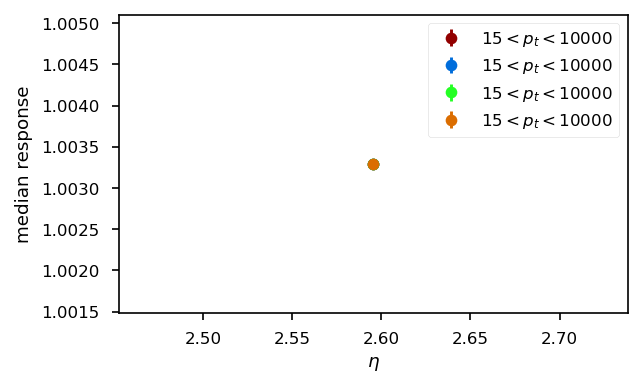

-------------------------
-------------------------
Fitting subsample:  _b
Images will be saved under  fig/response_pt_eta_b_oneBin_L5_LHEflav1_Herwig-TTBAR-JME
N converge =  1 N_not_converge =  0


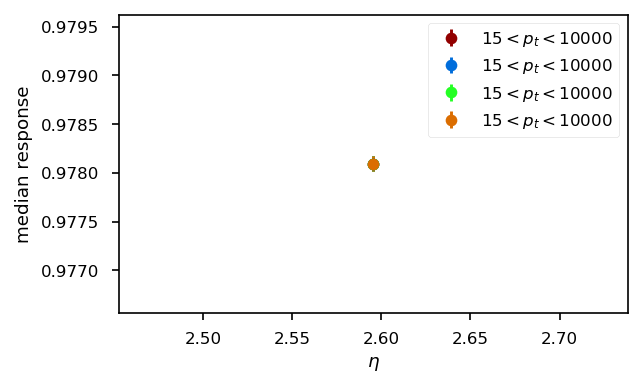

-------------------------
-------------------------
Fitting subsample:  _c
Images will be saved under  fig/response_pt_eta_c_oneBin_L5_LHEflav1_Herwig-TTBAR-JME
N converge =  1 N_not_converge =  0


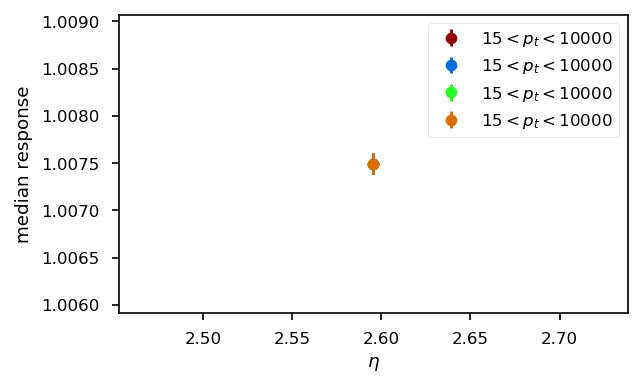

-------------------------
-------------------------
Fitting subsample:  _ud
Images will be saved under  fig/response_pt_eta_ud_oneBin_L5_LHEflav1_Herwig-TTBAR-JME
N converge =  1 N_not_converge =  0


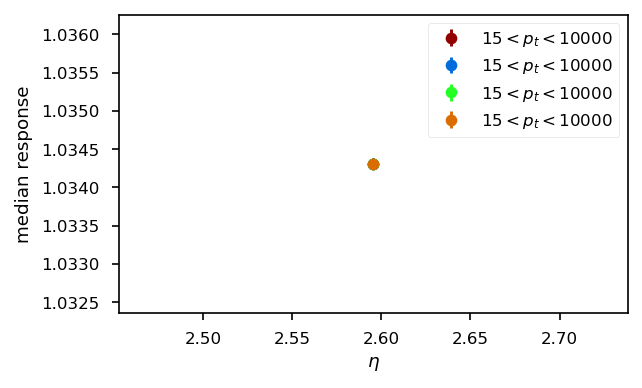

-------------------------
-------------------------
Fitting subsample:  _s
Images will be saved under  fig/response_pt_eta_s_oneBin_L5_LHEflav1_Herwig-TTBAR-JME
N converge =  1 N_not_converge =  0


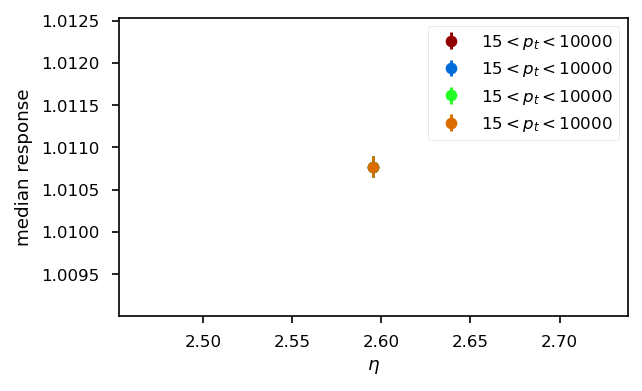

-------------------------
-------------------------
Fitting subsample:  _g
Images will be saved under  fig/response_pt_eta_g_oneBin_L5_LHEflav1_Herwig-TTBAR-JME
N converge =  1 N_not_converge =  0


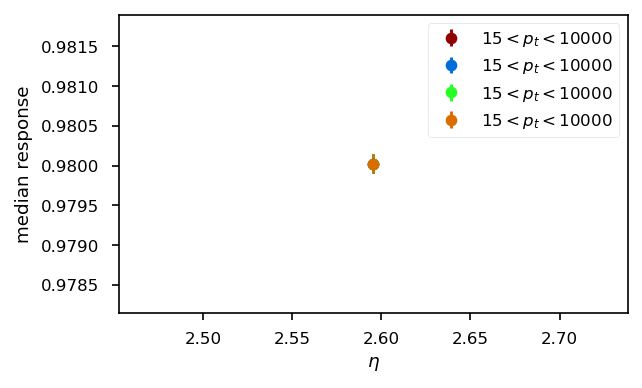

-------------------------
-------------------------
Fitting subsample:  _bbar
Images will be saved under  fig/response_pt_eta_bbar_oneBin_L5_LHEflav1_Herwig-TTBAR-JME
N converge =  1 N_not_converge =  0


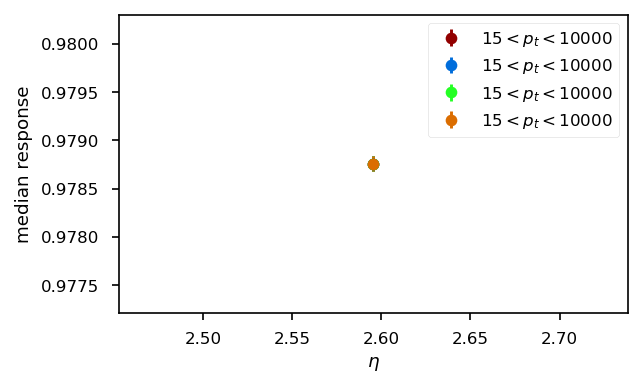

-------------------------
-------------------------
Fitting subsample:  _cbar
Images will be saved under  fig/response_pt_eta_cbar_oneBin_L5_LHEflav1_Herwig-TTBAR-JME
N converge =  1 N_not_converge =  0


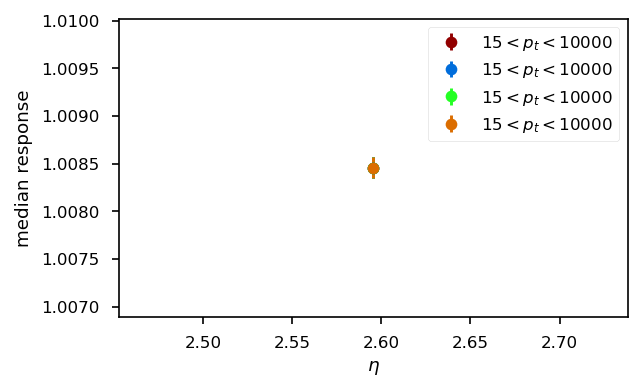

-------------------------
-------------------------
Fitting subsample:  _udbar
Images will be saved under  fig/response_pt_eta_udbar_oneBin_L5_LHEflav1_Herwig-TTBAR-JME
N converge =  1 N_not_converge =  0


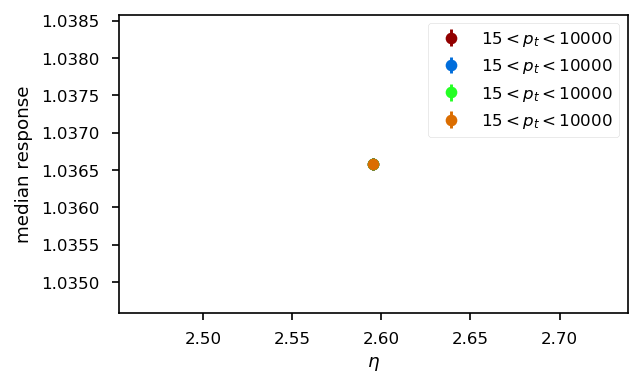

-------------------------
-------------------------
Fitting subsample:  _sbar
Images will be saved under  fig/response_pt_eta_sbar_oneBin_L5_LHEflav1_Herwig-TTBAR-JME
N converge =  1 N_not_converge =  0


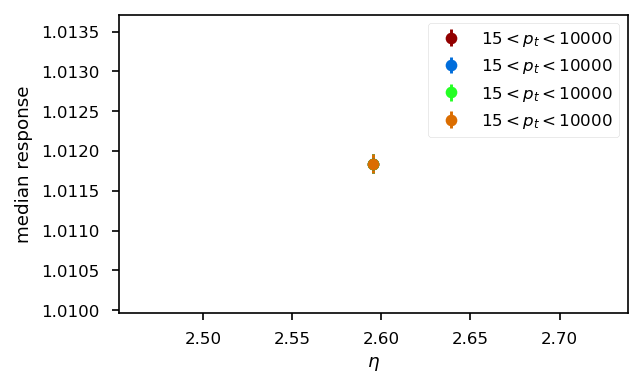

In [104]:
# load_fit_res=False
combine_antiflavour = False
subsamples = ['', '_b', '_c', '_ud', '_s', '_g', '_bbar', '_cbar', '_udbar', '_sbar']
# subsamples = ['_b', '_c', '_ud', '_s', '_g']
# subsamples = ['', '_ud', '_g'] # , '_b']
for samp in subsamples:
    print('-'*25)
    print('-'*25)
    print('Fitting subsample: ', samp)
    if load_fit_res:
        mean = read_data("Mean", samp)
        meanvar = read_data("MeanVar", samp)
        median = read_data("Mean", samp)
        medianstd = read_data("MedianStd", samp)
#         width = read_data("Width")
#         median = read_data(median, "Median")
    else:
        mean, meanvar, median, medianstd = fit_responses(output, samp)
        medians.append(median[0][0])
        medianstds.append(medianstd[0][0])
        for data, name in zip([mean, meanvar, median, medianstd],["Mean", "MeanVar", "Median", "MedianStd"]):
            save_data(data, name, samp)
            
    meanstd = np.sqrt(meanvar)
            
    if fine_etabins or :
        plot_corrections_eta(median, samp, medianstd)
    else:
        plot_corrections(mean, samp, meanstd)

In [332]:
# # load_fit_res=False
# subsamples = ['_b', '_c', '_ud', '_s', '_g', '_bbar', '_cbar', '_udbar', '_sbar']
# # subsamples = ['', '_ud', '_g'] # , '_b']
# for samp in subsamples:
#     print('-'*25)
#     print('-'*25)
#     print('Fitting subsample: ', samp)
#     if load_fit_res:
#         mean = read_data("Mean", samp)
#         meanvar = read_data("MeanVar", samp)
#         median = read_data("Mean", samp)
#         medianstd = read_data("MedianStd", samp)
# #         width = read_data("Width")
# #         median = read_data(median, "Median")
#     else:
#         mean, meanvar, median, medianstd = fit_responses(output, samp)
#         for data, name in zip([mean, meanvar, median, medianstd],["Mean", "MeanVar", "Median", "MedianStd"]):
#             save_data(data, name, samp)
            
#     meanstd = np.sqrt(meanvar)
            
#     if fine_etabins:
#         plot_corrections_eta(median, samp, medianstd)
#     else:
#         plot_corrections(mean, samp, meanstd)

### Fitting the mean responses

In [333]:
samp = '_b'
etabin = 1

mean = read_data("Mean", samp)
meanvar = read_data("MeanVar", samp)

In [334]:
means = mean[:, etabin]
means2fit = means[means!=0.0]
ptbins2fit = ptbins[:-1][means!=0.0]
meanvar2fit = np.abs(meanvar[means!=0.0,etabin])

xvals = np.linspace(ptbins2fit.min() - (0.5), ptbins2fit.max()+(ptbins2fit[-1]-ptbins2fit[-11]),1000)

In [335]:
import scipy as sp

In [336]:
def ptscale2int(x, ptbins):
    ptmax = max(np.log10(ptbins))
    ptmin = min(np.log10(ptbins))
    z = np.log10(x)
    return ((z-ptmin)-(ptmax-z))/(ptmax-ptmin);

# def int2pt(z, ptbins):
#     Mi = np.min(np.log10(ptbins))
#     Ma = np.max(np.log10(ptbins))
#     pts = z/2*(Ma-Mi) + (Ma + Mi)/2
#     return 10**pts

In [337]:
def sum_cheb_tmp(x, ptbins, *p):
    c0, c1, c2, c3, c4 = p
    xs = ptscale2int(x, ptbins)
    res = (c0 * sp.special.eval_chebyt(0, xs) +
           c1 * sp.special.eval_chebyt(1, xs) + 
           c2 * sp.special.eval_chebyt(2, xs) + 
           c3 * sp.special.eval_chebyt(3, xs) + 
           c4 * sp.special.eval_chebyt(4, xs) )
    return res

def sum_cheb5_tmp(x, ptbins, *p):
    c0, c1, c2, c3, c4, c5 = p
    xs = ptscale2int(x, ptbins)
    res = (c0 * sp.special.eval_chebyt(0, xs) +
           c1 * sp.special.eval_chebyt(1, xs) + 
           c2 * sp.special.eval_chebyt(2, xs) + 
           c3 * sp.special.eval_chebyt(3, xs) + 
           c4 * sp.special.eval_chebyt(4, xs) + 
           c5 * sp.special.eval_chebyt(5, xs) )
    return res

def sum_cheb3_tmp(x, ptbins, *p):
    c0, c1, c2, c3 = p
    xs = ptscale2int(x, ptbins)
    res = (c0 * sp.special.eval_chebyt(0, xs) +
           c1 * sp.special.eval_chebyt(1, xs) + 
           c2 * sp.special.eval_chebyt(2, xs) + 
           c3 * sp.special.eval_chebyt(3, xs) )
    return res

def sum_cheb2_tmp(x, ptbins, *p):
    c0, c1, c2 = p
    xs = ptscale2int(x, ptbins)
    res = (c0 * sp.special.eval_chebyt(0, xs) +
           c1 * sp.special.eval_chebyt(1, xs) + 
           c2 * sp.special.eval_chebyt(2, xs) )
    return res

In [338]:
def response_fnc(x, *p):
    p0, p1, p2, p3, p4, p5 = p
    return p0+(p1/((np.log10(x)**2)+p2)) + (p3*np.exp(-p4*((np.log10(x)-p5)*(np.log10(x)-p5))))
#     return A*np.exp(-(x-mu)**2/(2.*sigma**2))

In [592]:
init_vals_2014 = {
    'b':
    [[0.540002, 13.8495, 17.8549, -0.215711, 0.576285, 1.42258],
    [0.73119, 7.52866, 17.3681, -0.078402, 1.21665, 1.69878],
    [0.999952, 0.0322738, -1.05606, -19.6994, 0.720321, -1.58314],
    [0.135913, 7.92441, 3.85698, -0.804604, 1.11911, 0.732041]],
    'c' :
    [[ 0.940259, 0.705481, 0.23917, -0.826926, 0.311473, -0.514041],
    [0.982083, 0.238007, 4.35924, -0.0314618, 5.91028, 1.67749],
    [0.733505, 7.26794, 12.2028, -0.756302, 0.0895257, -1.96324],
    [0.932305, 1.15954, 17.1731, -0.471313, 2.58424, 0.254917]],
    'g' :
    [[0.877892, 3.10194, 1.16568, -677.876, 0.0325026, -12.9485],
    [0.983775, 0.247943, 1.55373, -0.0254802, 3.35748, 1.71263],
    [-0.972548, 38.8683, 2.47151, -44.0233, 0.0901665, -3.15495],
    [1.0655, -0.0680325, -0.509038, -8.59434e+06, 42.6162, 0.357177]],
    'd':
    [[1.28488, -46.3648, 151.749, -0.0108461, 15.4256, 1.63377],
    [ 1.50931, -118.71, 224.19, -0.0196468, 4.62655, 1.51581],
    [0.692016, 8.26488, 11.1655, -0.802769, 0.116182, -1.16094],
    [1.01244, -0.0926519, -0.12138, -3.69494e+07, 7.15634, -0.625288]],   
    's':
    [[1.28488, -46.3648, 151.749, -0.0108461, 15.4256, 1.63377],
    [ 1.50931, -118.71, 224.19, -0.0196468, 4.62655, 1.51581],
    [0.692016, 8.26488, 11.1655, -0.802769, 0.116182, -1.16094],
    [1.01244, -0.0926519, -0.12138, -3.69494e+07, 7.15634, -0.625288]],
    '':
    [[0.540002, 13.8495, 17.8549, -0.215711, 0.576285, 1.42258],
    [0.73119, 7.52866, 17.3681, -0.078402, 1.21665, 1.69878],
    [0.999952, 0.0322738, -1.05606, -19.6994, 0.720321, -1.58314],
    [0.135913, 7.92441, 3.85698, -0.804604, 1.11911, 0.732041]],
    
}

Better starting fit values I found

In [593]:
init_vals_2014['b'][0] = [ 9.81014871e-01, -6.46744813e-03, -1.05658840e+00,  5.35445486e+03, 2.99200015e+01,  1.21399356e+02]
init_vals_2014['b'][3] = [ 9.81014871e-01, -6.46744813e-03, -1.05658840e+00,  5.35445486e+03, 2.99200015e+01,  1.21399356e+02]

In [594]:
def sum_cheb_tmp(x, ptbins, *p):
    c0, c1, c2, c3, c4 = p
    xs = ptscale2int(x, ptbins)
    res = (c0 * sp.special.eval_chebyt(0, xs) +
           c1 * sp.special.eval_chebyt(1, xs) + 
           c2 * sp.special.eval_chebyt(2, xs) + 
           c3 * sp.special.eval_chebyt(3, xs) + 
           c4 * sp.special.eval_chebyt(4, xs) )
    return res

In [595]:
mean = read_data("Median", samp)[:,etabin]
read_data("Mean", samp)[:,etabin]
mean

array([0.        , 0.        , 1.04280477, 1.04192556, 1.03913808,
       1.03867998, 1.03838011, 1.03874682, 1.03736147, 1.03766465,
       1.03669065, 1.03282196, 1.02929341, 1.02637084, 1.02401553,
       1.01964383, 1.01956958, 1.01490575, 1.01522059, 1.0054182 ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        ])

array([       nan,        nan, 1.04378218, 1.04080274, 1.03815481,
       1.03656798, 1.03563762, 1.03514989, 1.03385748, 1.03254754,
       1.03056052, 1.0272457 , 1.02402522, 1.02092234, 1.01921034,
       1.01530265, 1.01521018, 1.01271466, 1.01228814, 1.00582192,
             -inf,       -inf,        nan,        nan,        nan,
              nan,        nan,        nan])

In [596]:
mean==numpy.float64
type(mean[2])

/tmp/anpotreb/ipykernel_28388/2149921351.py:1: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  mean==numpy.float64


False

numpy.float64

In [597]:
# validpt_mask = np.isnan(mean)


### Fitting the mean responses

In [598]:
my_mapping = {"": "aJ",
              "_b": "bT",
              "_c": "cT",
              "_s": "sT",
              "_g": "gT",
              "_ud": "qT"}

Winter 14 fit failed


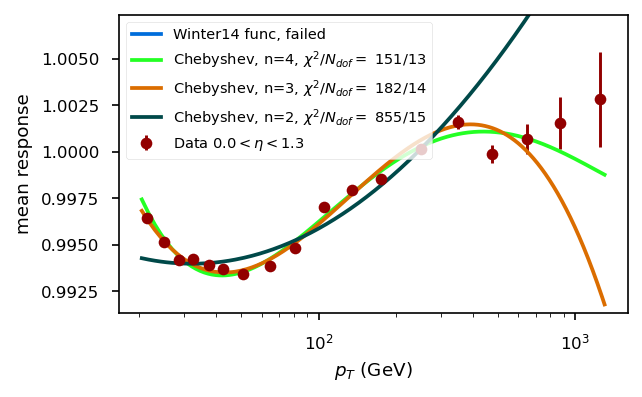

Winter 14 fit failed


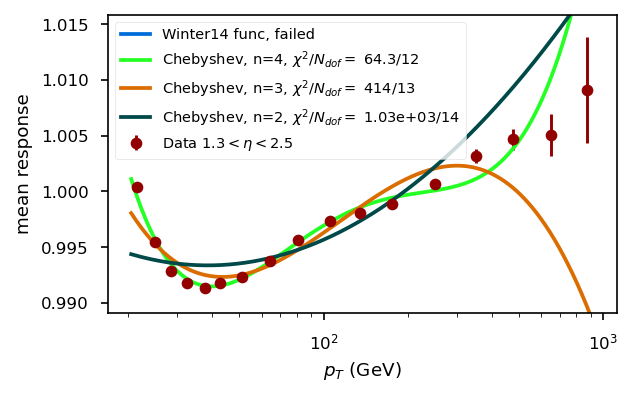

/cvmfs/sft-nightlies.cern.ch/lcg/views/dev4/Wed/x86_64-centos7-gcc11-opt/lib/python3.9/site-packages/scipy/optimize/_minpack_py.py:833: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',


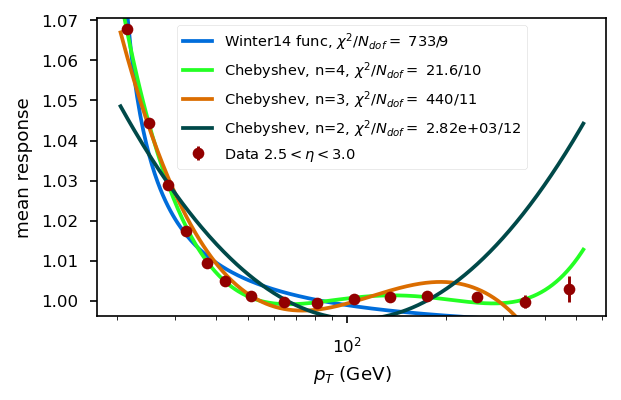

Winter 14 fit failed


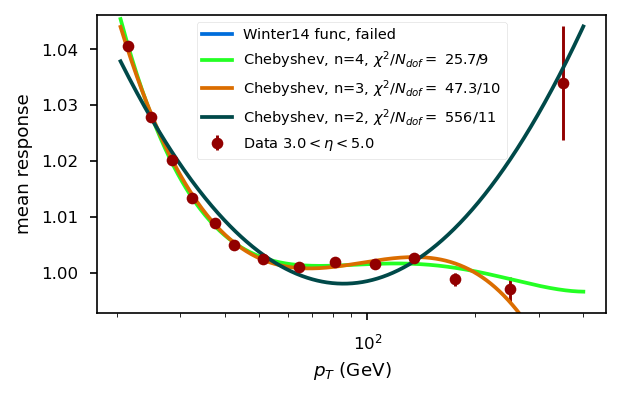

/cvmfs/sft-nightlies.cern.ch/lcg/views/dev4/Wed/x86_64-centos7-gcc11-opt/lib/python3.9/site-packages/scipy/optimize/_minpack_py.py:833: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',


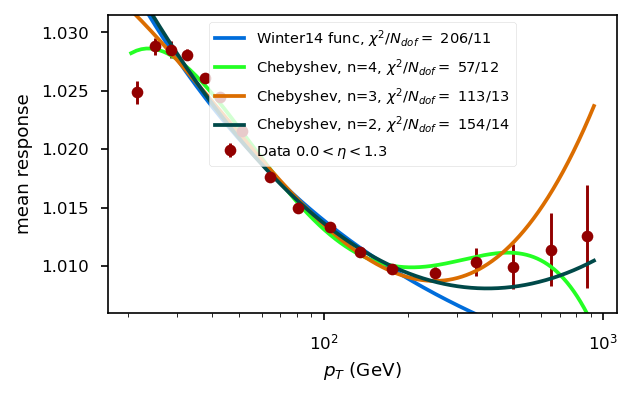

Winter 14 fit failed


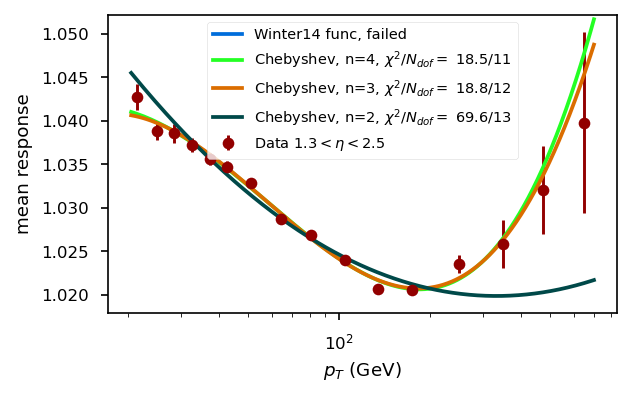

Winter 14 fit failed


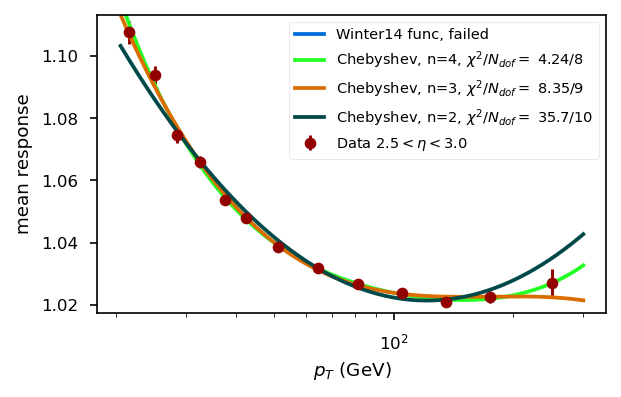

/cvmfs/sft-nightlies.cern.ch/lcg/views/dev4/Wed/x86_64-centos7-gcc11-opt/lib/python3.9/site-packages/scipy/optimize/_minpack_py.py:833: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',


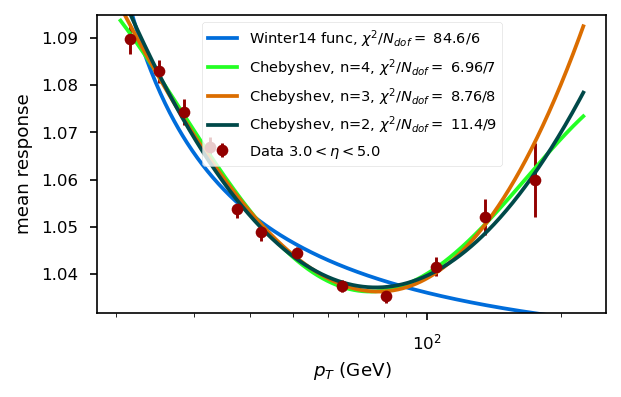

/tmp/anpotreb/ipykernel_28388/4222208775.py:3: RuntimeWarning: overflow encountered in exp
  return p0+(p1/((np.log10(x)**2)+p2)) + (p3*np.exp(-p4*((np.log10(x)-p5)*(np.log10(x)-p5))))


Winter 14 fit failed


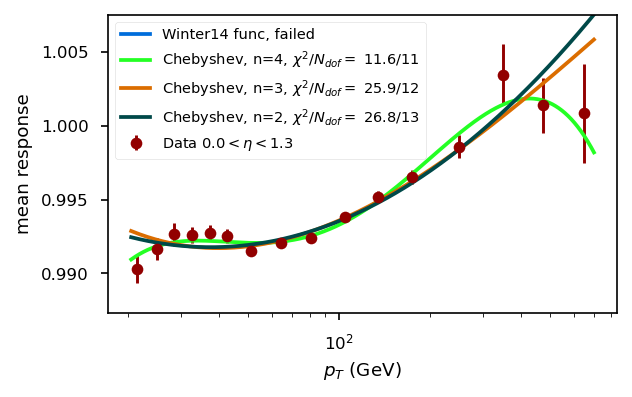

Winter 14 fit failed


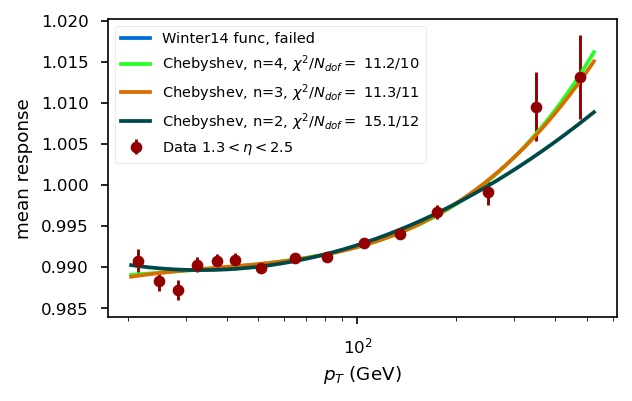

/tmp/anpotreb/ipykernel_28388/4222208775.py:3: RuntimeWarning: overflow encountered in exp
  return p0+(p1/((np.log10(x)**2)+p2)) + (p3*np.exp(-p4*((np.log10(x)-p5)*(np.log10(x)-p5))))


Winter 14 fit failed


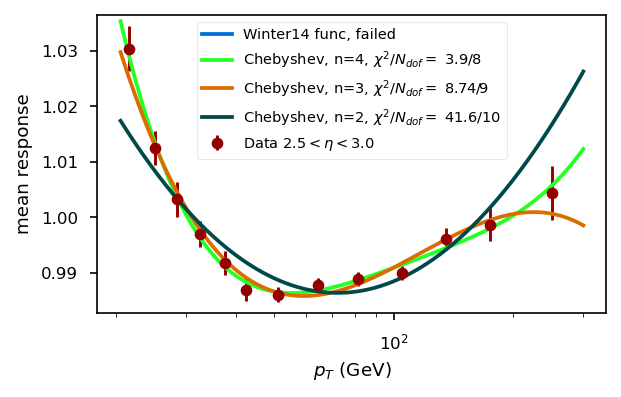

Winter 14 fit failed


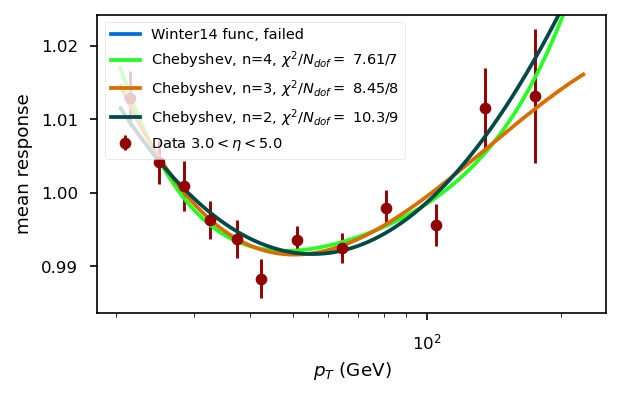

Winter 14 fit failed


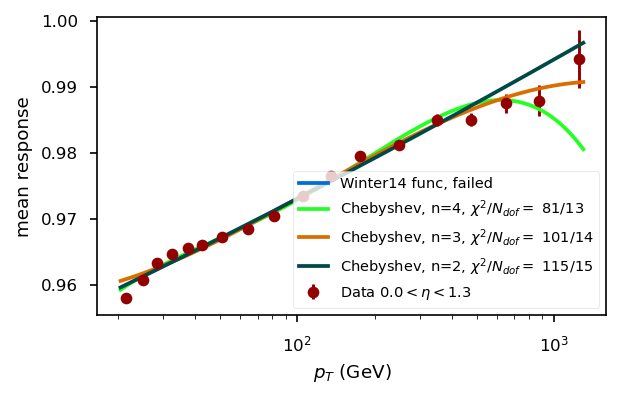

Winter 14 fit failed


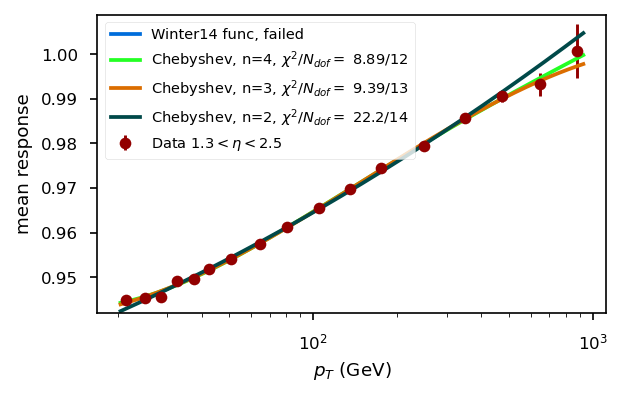

Winter 14 fit failed


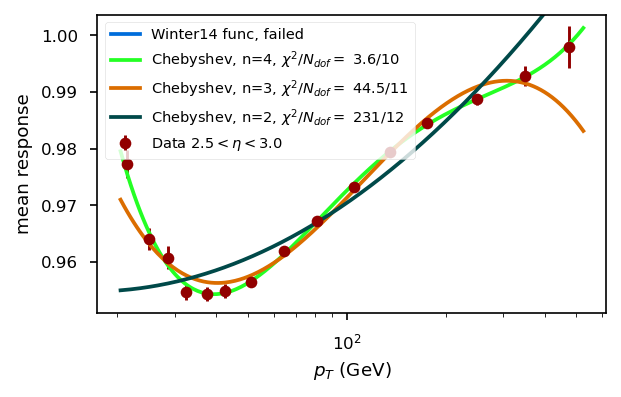

/tmp/anpotreb/ipykernel_28388/4222208775.py:3: RuntimeWarning: overflow encountered in exp
  return p0+(p1/((np.log10(x)**2)+p2)) + (p3*np.exp(-p4*((np.log10(x)-p5)*(np.log10(x)-p5))))


Winter 14 fit failed


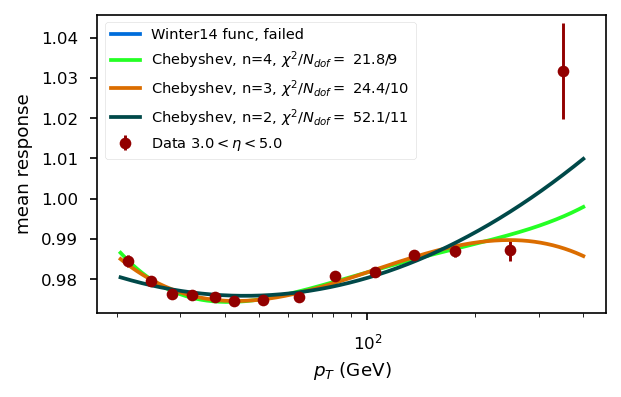

Winter 14 fit failed


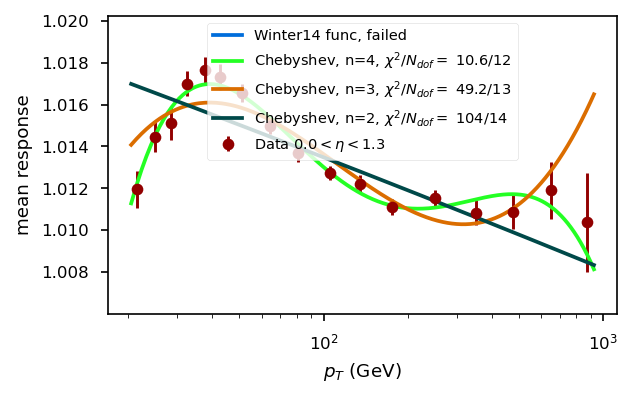

Winter 14 fit failed


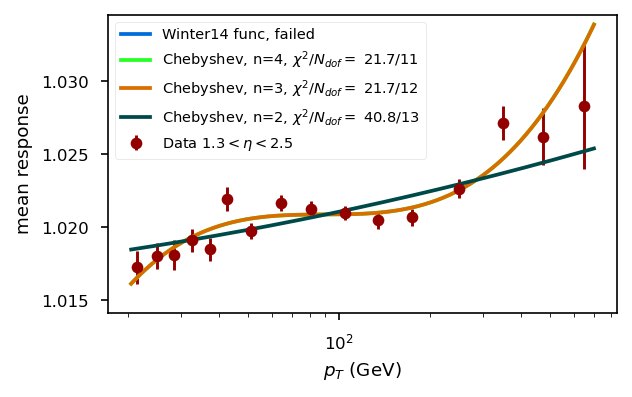

Winter 14 fit failed


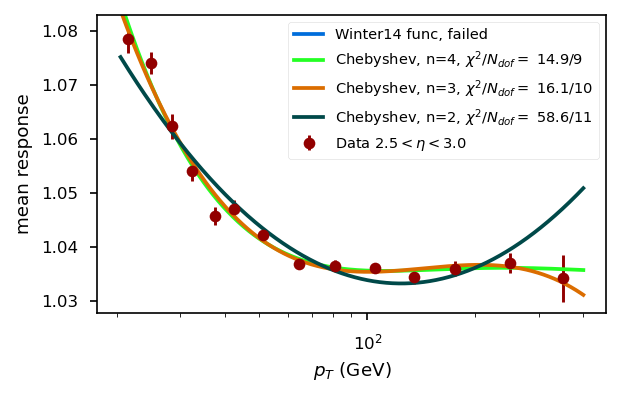

/cvmfs/sft-nightlies.cern.ch/lcg/views/dev4/Wed/x86_64-centos7-gcc11-opt/lib/python3.9/site-packages/scipy/optimize/_minpack_py.py:833: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',


Winter 14 fit failed


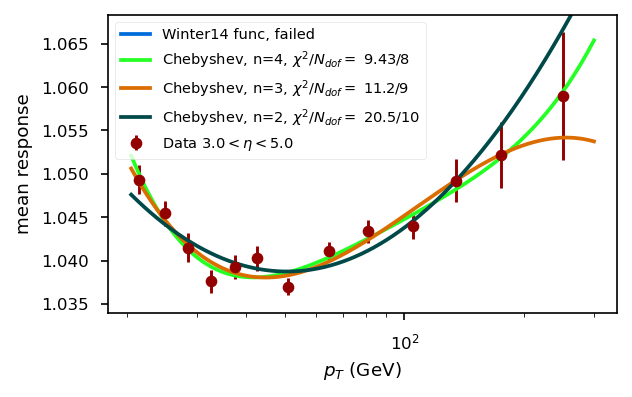

Winter 14 fit failed


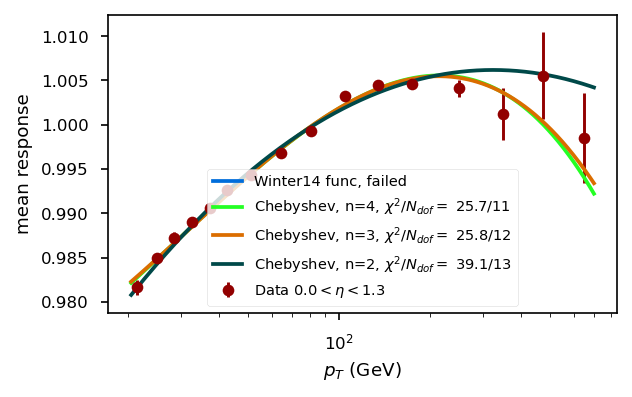

Winter 14 fit failed


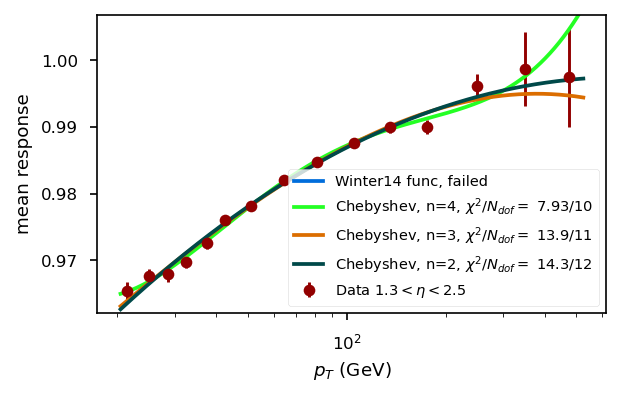

/tmp/anpotreb/ipykernel_28388/4222208775.py:3: RuntimeWarning: overflow encountered in exp
  return p0+(p1/((np.log10(x)**2)+p2)) + (p3*np.exp(-p4*((np.log10(x)-p5)*(np.log10(x)-p5))))


Winter 14 fit failed


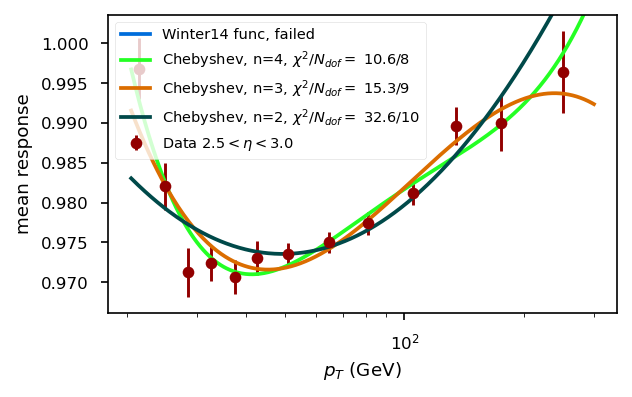

Winter 14 fit failed


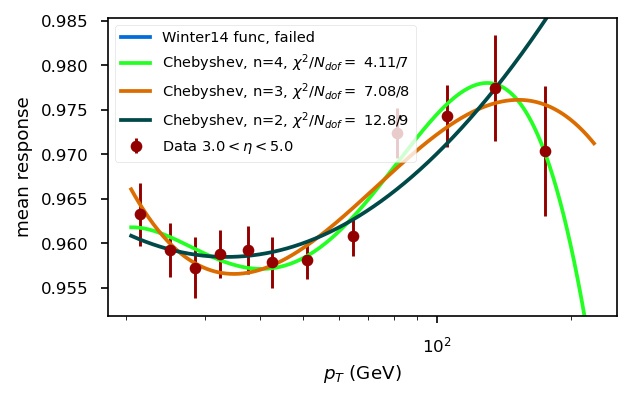

In [601]:
import sympy 
from sympy import chebyshevt
  
x = sympy.symbols('x')

subsamples = ['','_b', '_c', '_ud', '_g', '_s']
# subsamples = ['_b', '_c']


fit_res_all ={}
# etabins_all ={}
# nofpars_all ={}
for samp in subsamples:
    fit_res = []
    etabins_samp = []
    nofpars = []
    for etabin in range(4):
        mean = 1/read_data("Median", samp)[:,etabin]
        meanvar = mean**2*read_data("MedianStd", samp)[:,etabin]**2

        start = np.searchsorted(ptbins_c, 20, side='left')
        mean_range = range(start-1, len(mean)-8)
        

#         mean_range = mean_range_pt[:-1]

#         ptbins2fit = ptbins[mean_range_pt]
#         ptbins2fit = (ptbins2fit[:-1]+ptbins2fit[1:])/2
        means = mean[mean_range]
        ptbins2fit = ptbins_c[mean_range]
        validpt_mask = ~(np.isnan(means) | np.isinf(means) | (means==0))
        
        means2fit = means[validpt_mask]
        ptbins2fit = ptbins2fit[validpt_mask]
        meanvar2fit = np.abs(meanvar[mean_range][validpt_mask])
        
        
        fit_min_lim = min(ptbins[:-1][mean_range][validpt_mask])
        fit_max_lim = max(ptbins[1:][mean_range][validpt_mask])

        xvals = np.linspace(ptbins2fit.min() - (1), ptbins2fit.max()+50,1000) #-200 to plot the fitted curved outside of the points
        def sum_cheb(x, *p):
            return sum_cheb_tmp(x, ptbins2fit, *p)
        def sum_cheb5(x, *p):
            return sum_cheb5_tmp(x, ptbins2fit, *p)    
        def sum_cheb3(x, *p):
            return sum_cheb3_tmp(x, ptbins2fit, *p)  
        def sum_cheb2(x, *p):
            return sum_cheb2_tmp(x, ptbins2fit, *p)  
            
        try:
            p_resp, arr = curve_fit(response_fnc, ptbins2fit, means2fit, p0=init_vals_2014[samp[-1:]][etabin]) #0.793149, 4.60568, 11.1553, -0.123262, 0.878497, 1.52041
            p_resp_err, arr = curve_fit(response_fnc, ptbins2fit, means2fit, p0=p_resp, sigma=np.sqrt(meanvar2fit))
        except(RuntimeError):
            print("Winter 14 fit failed")
            p_resp, p_resp_err = [[np.nan]*6]*2
        #      = np.nan*6

        # p_resp_err
        p_cheb1, arr = curve_fit(sum_cheb, ptbins2fit, means2fit, p0=[ 1, 1, 1, 1, 1])
        p_cheb, arr = curve_fit(sum_cheb, ptbins2fit, means2fit, p0=p_cheb1, sigma=np.sqrt(meanvar2fit))
        p_cheb5_1, arr = curve_fit(sum_cheb5, ptbins2fit, means2fit, p0=[ 1, 1, 1, 1, 1, 1])
        p_cheb5, arr = curve_fit(sum_cheb5, ptbins2fit, means2fit, p0=p_cheb5_1, sigma=np.sqrt(meanvar2fit))
        p_cheb3_1, arr = curve_fit(sum_cheb3, ptbins2fit, means2fit, p0=[ 1, 1, 1, 1])
        p_cheb3, arr = curve_fit(sum_cheb3, ptbins2fit, means2fit, p0=p_cheb3_1, sigma=np.sqrt(meanvar2fit))
        p_cheb2_1, arr = curve_fit(sum_cheb2, ptbins2fit, means2fit, p0=[ 1, 1, 1])
        p_cheb2, arr = curve_fit(sum_cheb2, ptbins2fit, means2fit, p0=p_cheb2_1, sigma=np.sqrt(meanvar2fit))
        
        expr = 0
        for ii in range(len(p_cheb3)):
            expr+=p_cheb3[ii]* chebyshevt(ii,x)
        poly_coefs = np.array(sympy.Poly(expr).all_coeffs(), dtype=float)
#         len(poly_coefs)
        
#         etabins_samp = np.concatenate([etabins_samp,[etabins_mod[etabin], etabins_mod[etabin+1]]])
        fit_res = np.concatenate([fit_res,
                                  [etabins_mod[etabin], etabins_mod[etabin+1],
                                   len(p_cheb3), 
                                   fit_min_lim, fit_max_lim],
                                  p_cheb3 ])
        nofpars.append(len(p_cheb3))
        
        yvals_resp = response_fnc(xvals, *p_resp)
        yvals_resp_err = response_fnc(xvals, *p_resp_err)
        yvals = sum_cheb(xvals, *p_cheb)
#         yvals1 = sum_cheb(xvals, *p_cheb1)
        yvalsC5 = sum_cheb5(xvals, *p_cheb5)
#         yvalsC5_1 = sum_cheb5(xvals, *p_cheb5_1)
        yvalsC3 = sum_cheb3(xvals, *p_cheb3)
        yvalsC2 = sum_cheb2(xvals, *p_cheb2)

        chi2_resp = np.sum((response_fnc(ptbins2fit, *p_resp_err) - means2fit)**2/meanvar2fit)
        chi2_C4 = np.sum((sum_cheb(ptbins2fit, *p_cheb) - means2fit)**2/meanvar2fit)
        chi2_C5 = np.sum((sum_cheb5(ptbins2fit, *p_cheb5) - means2fit)**2/np.abs(meanvar2fit))
        chi2_C3 = np.sum((sum_cheb3(ptbins2fit, *p_cheb3) - means2fit)**2/np.abs(meanvar2fit))
        chi2_C2 = np.sum((sum_cheb2(ptbins2fit, *p_cheb2) - means2fit)**2/np.abs(meanvar2fit))
        Ndof_C4 = len(ptbins2fit) - 5
        Ndof_C5 = len(ptbins2fit) - 6
        Ndof_C3 = len(ptbins2fit) - 4
        Ndof_C2 = len(ptbins2fit) - 3
        Ndof_resp = len(ptbins2fit) - 6


        fig, ax = plt.subplots()

        plt.errorbar(ptbins2fit, means2fit, yerr=np.sqrt(np.abs(meanvar2fit)), marker='o',
                     linestyle="none", label=f'Data {etabins_mod[etabin]}'+r'$<\eta<'+f'${etabins_mod[etabin+1]}')

        eta_string = '_eta'+str(etabins_mod[etabin])+'to'+str(etabins_mod[etabin+1])
        eta_string = eta_string.replace('.','')
        if np.isnan(chi2_resp): 
            winter14_lab = 'Winter14 func, failed'
        else:
            winter14_lab= 'Winter14 func, '+r'$\chi^2/N_{dof} = $'+r' {0:0.3g}/{1:0.0f}'.format(chi2_resp, Ndof_resp)

        ax.plot(xvals, yvals_resp_err, label=winter14_lab, linewidth=1.8);
        ax.plot(xvals, yvals, label=r'Chebyshev, n=4, '+r'$\chi^2/N_{dof} = $'+r' {0:0.3g}/{1:0.0f}'.format(chi2_C4, Ndof_C4),linewidth=1.8);
#         ax.plot(xvals, yvalsC5, label=r'Chebyshev, n=5, '+r'$\chi^2/N_{dof} = $'+r' {0:0.3g}/{1:0.0f}'.format(chi2_C5, Ndof_C5),linewidth=1.8);
        ax.plot(xvals, yvalsC3, label=r'Chebyshev, n=3, '+r'$\chi^2/N_{dof} = $'+r' {0:0.3g}/{1:0.0f}'.format(chi2_C3, Ndof_C3),linewidth=1.8);
        ax.plot(xvals, yvalsC2, label=r'Chebyshev, n=2, '+r'$\chi^2/N_{dof} = $'+r' {0:0.3g}/{1:0.0f}'.format(chi2_C2, Ndof_C2),linewidth=1.8);

    
#         yerr_norm = np.concatenate([np.sqrt(meanvar[start:,[k2, k4, k6, k8]]) ])
#         y_norm = np.concatenate([mean_p[start:,[k2, k4, k6, k8]]])
    #     print("ynorm = ", y_norm)
    #     print("yerr = ", yerr_norm)
        std = np.sqrt(np.abs(meanvar2fit))
        norm_pos = (std<0.1) &  (std != np.inf)
    #     print("(yerr_norm+y_norm)[norm_pos]) = ", (yerr_norm+y_norm)[norm_pos])
        ax.set_ylim(np.min((means2fit-std)[norm_pos])-0.002 ,np.max((std+means2fit)[norm_pos])+0.002)

        ax.set_xlabel(r'$p_T$ (GeV)');
        ax.set_ylabel(r'mean response');
        ax.set_xscale('log')
        # ax.set_ylim([0.8,1.1])
        ax.legend(prop={'size': 7})
        if not test_run:
            plt.savefig('fig/response_fit'+samp+eta_string+'.png', dpi=plt.rcParamsDefault['figure.dpi']);
            plt.savefig('fig/response_fit'+samp+eta_string+'.pdf', dpi=plt.rcParamsDefault['figure.dpi']);
        else:
            plt.savefig('test/fig/response_fit'+samp+eta_string+'.png', dpi=plt.rcParamsDefault['figure.dpi']);
            plt.savefig('test/fig/response_fit'+samp+eta_string+'.pdf', dpi=plt.rcParamsDefault['figure.dpi']);
        # fig.set_size_inches(6, 4, forward=True)
        plt.show();
        plt.close();
        
    num = int(5 + fit_res[2])
    fit_res = np.reshape(fit_res,((len(fit_res)//num), num))
#     etabins_samp = np.reshape(etabins_samp,((len(etabins_samp)//2), 2))
    fit_res_all[my_mapping[samp]] = fit_res
#     etabins_all[my_mapping[samp]] = etabins_samp
#     nofpars_all[my_mapping[samp]] = nofpars
'a';

In [611]:
header_txt = ('# L5 flavor corrections for IC5 algorithm \n'+
'# [gJ] (gluons from diJet mixture) \n'+
'# [qJ] (uds quarks from diJet mixture) \n'+
'# [cJ] (c quark from diJet mixture) \n'+
'# [bJ] (b quark from diJet mixture) \n'+
'# [gT] (gluons from ttbar events) \n'+
'# [qT] (uds quarks from ttbar events) \n'+
'# [cT] (c quark from ttbar events) \n'+
'# [bT] (b quark from ttbar events) \n'+
'# energy mapping: ptGen = (pt - p5)/p6 \n'+
'# parametrization: p2+p3*logPt+p4*logPt^2, constant if Pt<p0 or Pt>p1 \n'+
'#etamin  etamax  #ofparameters  ptmin  ptmax    p2         p3        p4     mapping: p5        p6 ')

In [613]:
with open("Summer20UL18_V2_MC/Summer20UL18_V2_MC_L5Flavor_AK4chs.txt", 'w') as file:
    file.write(header_txt+'\n')
    for key in fit_res_all.keys():
        file.write('['+key+']\n')
        file.write('{1 JetEta 1 JetPt ([0] + [1]*log10(x) + [2]*log10(x)*log10(x) + [3]*log10(x)*log10(x)*log10(x)) Correction L5Flavor}\n')
        for row in fit_res_all[key]:
            file.write('\t'.join([str(item) for item in row[:2]])+'\t'+str(int(row[2]))+'\t'+'\t'.join([str(item) for item in row[3:]])+'\n');

4; ## to suppress printouts of write

### Fit a specific $\eta$ $p_T$ bin

In [236]:

mean = np.zeros((jetpt_length, jeteta_length))
median = np.zeros((jetpt_length, jeteta_length))
width = np.zeros((jetpt_length, jeteta_length))
chi2s = np.zeros((jetpt_length, jeteta_length))
meanvar = np.zeros((jetpt_length, jeteta_length))
#     idx = []

N_converge = 0
N_not_converge = 0

FitFigDir = 'fig/response_pt_eta'+samp+tag_full
print("Images will be saved under ", FitFigDir)
if not os.path.exists(FitFigDir):
    os.mkdir(FitFigDir)
    
edd = output['ptresponse'+samp].axis('ptresponse').edges()
plot_pt_edges = edd[0:np.nonzero(edd>=2.0)[0][0]]
# plot_pt_edges = output['ptresponse'+samp].axis('ptresponse').edges()[0:42] ##Put plotting limits to the histogram
hist_pt_edges = plot_pt_edges[1:-1]   #for plotting. To explude overflow from the plot
plot_response_axis = hist.Bin("jeteta", r"Jet $\eta$", hist_pt_edges)

xvals = output['ptresponse'+samp].axis('ptresponse').centers()[1:] #[1:] to exclude the second peak for low pt
f_xvals = np.linspace(0,5,5001)
response_edges = output['ptresponse'+samp].axis('ptresponse').edges()[1:]

Images will be saved under  fig/response_pt_eta_L5_fine_etaBins_QCD


In [237]:
# np.where(xvals>=p[1]+np.abs(p[2])*1.5)

In [238]:
samp=''

In [266]:
etabins

array([-5.191, -4.889, -4.716, -4.538, -4.363, -4.191, -4.013, -3.839,
       -3.664, -3.489, -3.314, -3.139, -2.964, -2.853, -2.65 , -2.5  ,
       -2.322, -2.172, -2.043, -1.93 , -1.83 , -1.74 , -1.653, -1.566,
       -1.479, -1.392, -1.305, -1.218, -1.131, -1.044, -0.957, -0.879,
       -0.783, -0.696, -0.609, -0.522, -0.435, -0.348, -0.261, -0.174,
       -0.087,  0.   ,  0.087,  0.174,  0.261,  0.348,  0.435,  0.522,
        0.609,  0.696,  0.783,  0.879,  0.957,  1.044,  1.131,  1.218,
        1.305,  1.392,  1.479,  1.566,  1.653,  1.74 ,  1.83 ,  1.93 ,
        2.043,  2.172,  2.322,  2.5  ,  2.65 ,  2.853,  2.964,  3.139,
        3.314,  3.489,  3.664,  3.839,  4.013,  4.191,  4.363,  4.538,
        4.716,  4.889,  5.191])

In [546]:
samp='_g'

In [549]:
ptbins

array([   15.,    17.,    20.,    23.,    27.,    30.,    35.,    40.,
          45.,    57.,    72.,    90.,   120.,   150.,   200.,   300.,
         400.,   550.,   750.,  1000.,  1500.,  2000.,  2500.,  3000.,
        3500.,  4000.,  4500.,  5000., 10000.])

In [552]:
# histoMi = output['ptresponse'+samp].integrate('jeteta', hist.Interval(4.538,  4.716)).integrate('pt', hist.Interval(15, 40))
# histoPl = output['ptresponse'+samp].integrate('jeteta', hist.Interval(-4.716, -4.538)).integrate('pt', hist.Interval(15, 40))

histoMi = output['ptresponse'+samp].integrate('jeteta', hist.Interval(0,  1.3)).integrate('pt', hist.Interval(23, 27))
histoPl = output['ptresponse'+samp].integrate('jeteta', hist.Interval(-1.3, 0)).integrate('pt', hist.Interval(23, 27))
histo = (histoMi+histoPl)
yvals = histo.values()[('QCD',)][1:]  #[1:] to exclude the second peak for low pt

N = histo.integrate('ptresponse').values()[('QCD',)]-histo.values()[('QCD',)][0]

####################### Calculate median and rms ############################
yvals_cumsum = np.cumsum(yvals)
med_bin = np.nonzero(yvals_cumsum>N/2)[0][0] if N>0 else 0
median = response_edges[med_bin] + (N/2 - yvals_cumsum[med_bin-1])/yvals[med_bin]*(response_edges[med_bin+1]
                                                                          - response_edges[med_bin])

hist_mean = np.sum(xvals*yvals)/sum(yvals) 
hist_rms = np.sqrt(np.sum(yvals*((hist_mean-xvals)**2))/sum(yvals))
medianstd = 1.253 * hist_rms/np.sqrt(N)

####################### Fitting ############################
nonzero_bins = np.sum(yvals>0)
if nonzero_bins<2 or N<50:
    p2=[0,0,0]
    chi2 = np.nan
    arr = np.array([[np.nan]*3]*3)
    Ndof = 0
#                 print("Too little data points, skipping p = ", p2)
else:
    try:
        p, arr = curve_fit(gauss, xvals, yvals, p0=[10,1,1])
        N_converge += 1
             ######## Second Gaussian ########
        xfit_l = np.where(xvals>=p[1]-np.abs(p[2])*1.5)[0][0]
        xfit_hs = np.where(xvals>=p[1]+np.abs(p[2])*1.5)[0]
        xfit_h = xfit_hs[0] if len(xfit_hs)>0 else len(xvals)
#                     print("xfit_l = ", xfit_l, ", xfit_h = ", xfit_h)

        if len(range(xfit_l,xfit_h))<6: #if there are only 3pnts, the uncertainty is infty
            xfit_l = xfit_l-1
            xfit_h = xfit_h+1
            if len(range(xfit_l,xfit_h))<6:
                xfit_l = xfit_l-1
                xfit_h = xfit_h+1
        if xfit_l<0:
            xfit_h-=xfit_l
            xfit_l = 0
        xvals2 = xvals[xfit_l: xfit_h]
        yvals2 = yvals[xfit_l: xfit_h]
#                     if ptBin.lo>290:
#                         print("xfit_l = ", xfit_l, ", h = ", xfit_h)
#                         print("yvals = ", yvals)
#                         print("yvals2 = ", yvals2)
        p2, arr = curve_fit(gauss, xvals2, yvals2, p0=p)

        ygaus = gauss(xvals, *p2)
        chi2 = sum((yvals-ygaus)**2/(yvals+1E-9))
        Ndof = len(xvals2)-3
#                     if chi2<50000:
#                         pass
#                         print("Fit converged, p = ", p2, ", chi2 = ", chi2 )
#                     else:
#                         print("Fit failed because of high chi2, p = ", p2, ", chi2 = ", chi2 )
    except(RuntimeError):
        p2=[0,0,0]
#                     print("Fit failed because of non-convergance, p = ", p2)
        chi2 = np.nan
        arr = np.array([[np.nan]*3]*3)
        Ndof = 0
        N_not_converge += 1

fgaus2 = gauss(f_xvals, *p2)
histo = histo.rebin('ptresponse', plot_response_axis)
width_ik = np.abs(p2[2])




/cvmfs/sft-nightlies.cern.ch/lcg/views/dev4/Mon/x86_64-centos7-gcc11-opt/lib/python3.9/site-packages/coffea/hist/hist_tools.py:665: RuntimeWarning: Reducing along axis <Bin (name=jeteta) instance at 0x7fabf0163f10>: requested stop 1.3 between bin boundaries, no interpolation is performed
  warnings.warn(
/cvmfs/sft-nightlies.cern.ch/lcg/views/dev4/Mon/x86_64-centos7-gcc11-opt/lib/python3.9/site-packages/coffea/hist/hist_tools.py:638: RuntimeWarning: Reducing along axis <Bin (name=jeteta) instance at 0x7fabf0163f10>: requested start -1.3 between bin boundaries, no interpolation is performed
  warnings.warn(


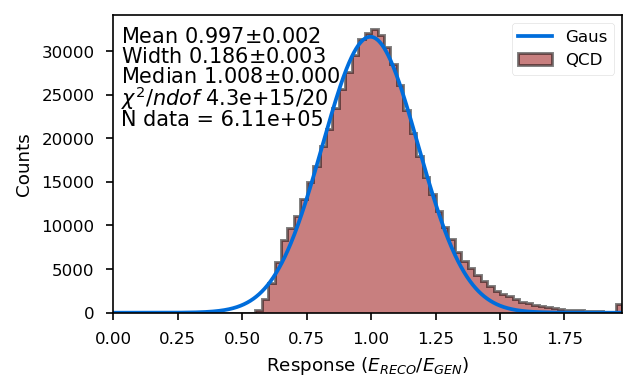

In [553]:
fig, ax2 = plt.subplots();
hist.plot1d(histo, ax=ax2, overlay='dataset', overflow='all',
            fill_opts={'alpha': .5, 'edgecolor': (0,0,0,0.3), 'linewidth': 1.4})
# ax2.plot(f_xvals, fgaus, label='Gaus',linewidth=1.8)
ax2.plot(f_xvals, fgaus2, label='Gaus',linewidth=1.8)
ax2.set_xlabel("Response ($E_{RECO}/E_{GEN}$)")
ax2.set_xlim(plot_pt_edges[[0,-1]])
h = ax2.get_ylim()[1]/1.05
plt.text(0.03,0.95*h,r'Mean {0:0.3f}$\pm${1:0.3f}'.format(p2[1], np.sqrt(arr[1,1])))
plt.text(0.03,0.88*h,r'Width {0:0.3f}$\pm${1:0.3f}'.format(width_ik, np.sqrt(arr[2,2])))
plt.text(0.03,0.81*h,r'Median {0:0.3f}$\pm${1:0.3f}'.format(median, medianstd))
plt.text(0.03,0.73*h,r'$\chi^2/ndof$ {0:0.2g}/{1:0.0f}'.format(chi2, Ndof))
plt.text(0.03,0.66*h,r'N data = {0:0.3g}'.format(N))
ax2.legend();

# plt.close();    

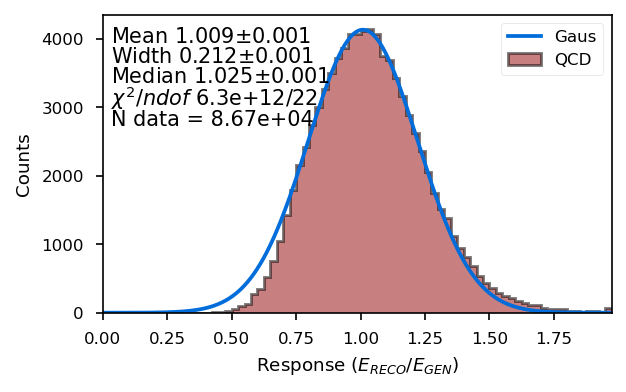

In [269]:
fig, ax2 = plt.subplots();
hist.plot1d(histo, ax=ax2, overlay='dataset', overflow='all',
            fill_opts={'alpha': .5, 'edgecolor': (0,0,0,0.3), 'linewidth': 1.4})
# ax2.plot(f_xvals, fgaus, label='Gaus',linewidth=1.8)
ax2.plot(f_xvals, fgaus2, label='Gaus',linewidth=1.8)
ax2.set_xlabel("Response ($E_{RECO}/E_{GEN}$)")
ax2.set_xlim(plot_pt_edges[[0,-1]])
h = ax2.get_ylim()[1]/1.05
plt.text(0.03,0.95*h,r'Mean {0:0.3f}$\pm${1:0.3f}'.format(p2[1], np.sqrt(arr[1,1])))
plt.text(0.03,0.88*h,r'Width {0:0.3f}$\pm${1:0.3f}'.format(width_ik, np.sqrt(arr[2,2])))
plt.text(0.03,0.81*h,r'Median {0:0.3f}$\pm${1:0.3f}'.format(median, medianstd))
plt.text(0.03,0.73*h,r'$\chi^2/ndof$ {0:0.2g}/{1:0.0f}'.format(chi2, Ndof))
plt.text(0.03,0.66*h,r'N data = {0:0.3g}'.format(N))
ax2.legend();

# plt.close();    

In [ ]:
print('-----'*10)
print("All done. Congrats!")